**DEEP LEARNING PROJEKT - Verkehrszeichen Klassifizierung:** In diesem Projekt werden wir “Deep Neural Networks und Convolutional Neural Networks” verwenden, um Verkehrszeichen zu klassifizieren. Mit dem deutschen Verkehrszeichendatensatz werden wir ein Modell trainieren, um Verkehrszeichen in natürlichen Bildern zu dekodieren.

Zuerst verbinden wir uns mit dem Drive. Sie können dann die Dateien "train.p", "test.p" und "valid.p" von diesem Link "https://bitbucket.org/jadslim/german-traffic-signs/src/master", die Datei signnames.csv von diesem Link "https://www.kaggle.com/imadmoussa/traffic-signs?select=signnames.csv" herunterladen und in einem neuen Ordner auf dem ihre Drive ablegen.


Wenn Sie den Datensatz nicht herunterladen möchten, können Sie diesem Code-Snippet verwendet. (Ich habe die Genauigkeit nicht getestet, aber ich denke, es wird funktionieren.)
"!git clone https://bitbucket.org/jadslim/german-traffic-signs"

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Bibliotheken, die vor der Implementierung des Codes verwendet werden sollen, müssen geladen sein (NumPy, Pandas, Keras, Matplotlib und OpenCV). Hier verwenden wir "numpy" für numerische Berechnungen, "Pandas" für den Import und die Verwaltung des Datensatzes, "Keras" für den schnellen Aufbau des Convolutional Neural Network mit weniger Code und "cv2" für einige Vorverarbeitungsschritte, die für eine effiziente Extraktion von Merkmalen aus den Bildern durch das CNN erforderlich sind .

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import keras 
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten 
from keras.layers.convolutional import Conv2D, MaxPooling2D 
from keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical 
from keras.preprocessing.image import ImageDataGenerator 
import pickle 
import pandas as pd 
import random 
import cv2 
  
np.random.seed(0) 

**Laden der Daten:** Wir werden Pandas verwenden, um signnames.csv zu laden, und pickle, um die Train-, Validation- und Test Pickle Dateien zu laden. Nach dem Extrahieren der Daten werden diese unter Verwendung der Wörterbuchbezeichnungen "Features" und "Labels" aufgeteilt.

In [ ]:
data = pd.read_csv("drive/My Drive/dataset/sign_names.csv") 
  
with open('drive/My Drive/dataset/train.p', 'rb') as f: 
    train_data = pickle.load(f) 
with open('drive/My Drive/dataset/valid.p', 'rb') as f: 
    val_data = pickle.load(f) 
with open('drive/My Drive/dataset/test.p', 'rb') as f: 
    test_data = pickle.load(f) 
  
# Extracting the labels from the dictionaries 
X_train, y_train = train_data['features'], train_data['labels'] 
X_val, y_val = val_data['features'], val_data['labels'] 
X_test, y_test = test_data['features'], test_data['labels'] 
  
#https://www.geeksforgeeks.org/opencv-and-keras-traffic-sign-classification-for-self-driving-car/

Die Zusammenfassung der Basisdaten finden Sie weiter unten.

In [ ]:
import numpy as np

n_train = y_train.shape[0]

n_test = y_test.shape[0]

image_shape = X_train[0].shape

n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
#https://github.com/aditbiswas1/P2-traffic-sign-classifier/blob/master/Traffic_Sign_Classifier.ipynb

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In den folgenden Diagrammen sehen Sie die Nummern der Elemente jeder Klasse der Datensätze "Train", "Test" und "Validation".

In [ ]:
def histogram_plot(dataset, label):
    """
    Plots a histogram of the input data.
        Parameters:
            dataset: Input data to be plotted as a histogram.
            lanel: A string to be used as a label for the histogram.
    """
    hist, bins = np.histogram(dataset, bins=n_classes)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.xlabel(label)
    plt.ylabel("Image count")
    plt.show()
    #https://github.com/mohamedameen93/German-Traffic-Sign-Classification-Using-TensorFlow/blob/master/Traffic_Sign_Classifier.ipynb

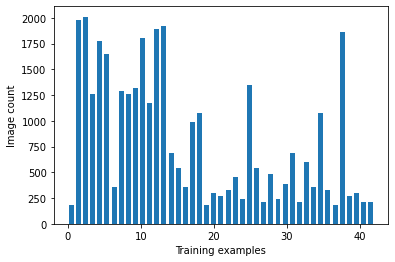

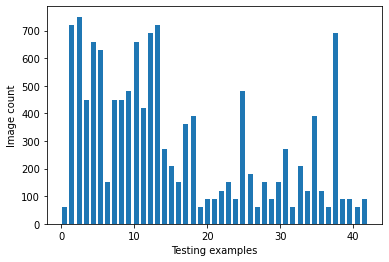

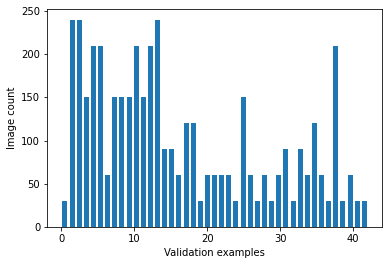

In [ ]:
histogram_plot(y_train, "Training examples")
histogram_plot(y_test, "Testing examples")
histogram_plot(y_val, "Validation examples")

Sie können 5 Proben von jeweils 43 Klassen mit ihren Sign-Namen beobachten. Wie Sie sehen können, unterscheiden sich alle Bilder in vielerlei Hinsicht.

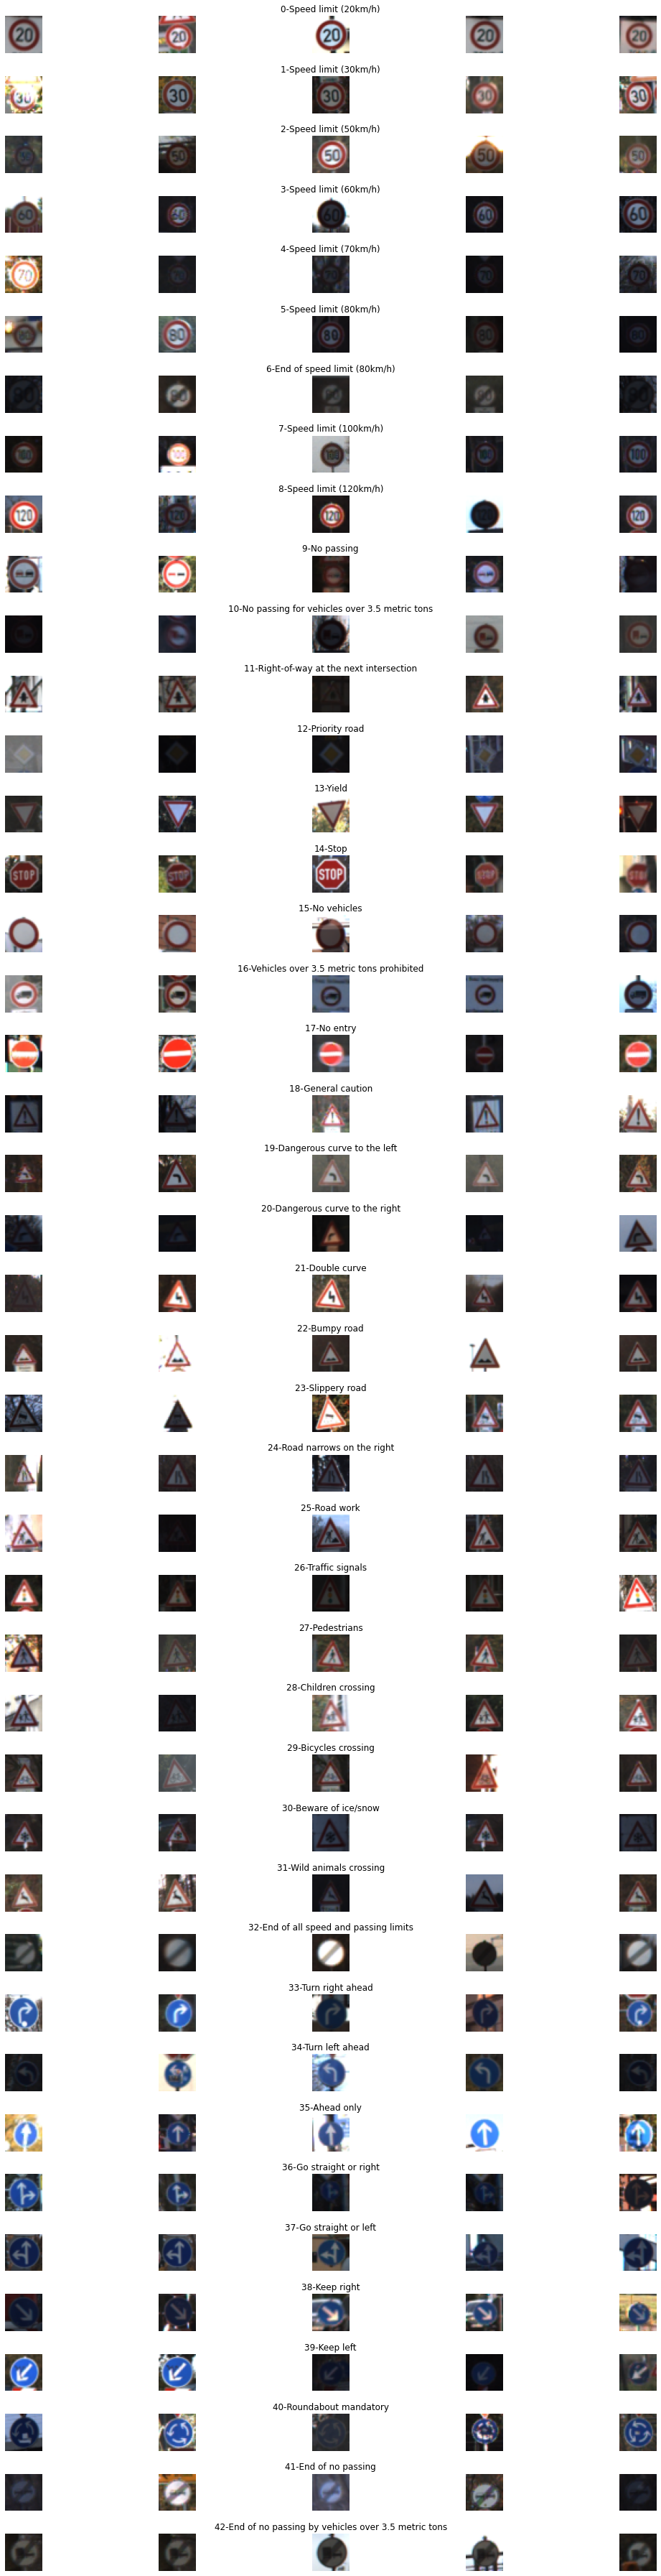

In [ ]:
num_of_sample=[]

cols=5
num_classes=43
fig,axs=plt.subplots(nrows=num_classes,ncols=cols,figsize=(15,50))
fig.tight_layout()

for i in range(cols):
  for j,raw in data.iterrows():
    x_selected=X_train[y_train==j]
    axs[j][i].imshow(x_selected[random.randint(0,len(x_selected)-1),:,:],cmap=plt.get_cmap('gray'))
    axs[j][i].axis("off")
    
    if i==2:
      axs[j][i].set_title(str(j)+'-'+raw['SignName'])
      num_of_sample.append(len(x_selected))
      #https://github.com/singhbir/Traffic_Sign_Classifier-/blob/master/Traffic_Sign_Classifier.ipynb

**Preprocessing der Daten mit OpenCV:**
Die Vorverarbeitung von Bildern vor dem Einspeisen in das Modell liefert sehr genaue Ergebnisse, da sie beim Extrahieren der komplexen Merkmale des Bildes hilfreich sind. OpenCV verfügt über einige integrierte Funktionen wie cvtColor () und EqualizeHist () für diese Aufgabe.

Zunächst werden die Bilder in Graustufenbilder konvertiert, um die Berechnung mithilfe der Funktion cvtColor () zu reduzieren.
Die Funktion EqualizeHist () erhöht die Kontraste des Bildes, indem die Intensitäten der Pixel durch Normalisieren mit den benachbarten Pixeln ausgeglichen werden.
Am Ende normalisieren wir die Pixelwerte zwischen 0 und 1, indem wir sie durch 255 teilen.

In [ ]:
def preprocessing(img): 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    img = cv2.equalizeHist(img) 
    img = img / 255
    return img 
  
X_train = np.array(list(map(preprocessing, X_train))) 
X_val = np.array(list(map(preprocessing, X_val))) 
X_test = np.array(list(map(preprocessing, X_test))) 
  
X_train = X_train.reshape(34799, 32, 32, 1) 
X_val = X_val.reshape(4410, 32, 32, 1) 
X_test = X_test.reshape(12630, 32, 32, 1) 
#https://www.geeksforgeeks.org/opencv-and-keras-traffic-sign-classification-for-self-driving-car/

Nach dem Umformen der Arrays ist es Zeit, sie für das Training in das Modell einzuspeisen. Um die Genauigkeit unseres CNN-Modells zu erhöhen, werden wir einen weiteren Schritt zum Generieren erweiterter Bilder mit dem ImageDataGenerator ausführen.

Dies geschieht, um eine Überanpassung der Trainingsdaten zu reduzieren, da das Erhalten unterschiedlicher Daten zu einem besseren Modell führt. Der Wert 0,1 wird als 10% interpretiert, während 10 der Rotationsgrad ist. Wir konvertieren die Beschriftungen auch in kategoriale Werte, wie wir es normalerweise tun.

In [ ]:
datagen = ImageDataGenerator(width_shift_range = 0.1,  
                  height_shift_range = 0.1,  
                  zoom_range = 0.2,  
                  shear_range = 0.1,  
                  rotation_range = 10) 
datagen.fit(X_train) 
  
y_train = to_categorical(y_train, 43) 
y_val = to_categorical(y_val, 43) 
y_test = to_categorical(y_test, 43)
#https://www.geeksforgeeks.org/opencv-and-keras-traffic-sign-classification-for-self-driving-car/

**Modell bauen**:
Das Dataset 43 Bildklassen enthält, setzen wir "num_classes" auf 43. Das Modell enthält zwei Conv2D-Ebenen, gefolgt von einer MaxPooling2D-Ebene. Dies erfolgt zweimal für die effektive Extraktion von Merkmalen, gefolgt von den dichten Schichten. Eine Dropout-Schicht von 0,5 wird hinzugefügt, um eine Überanpassung der Daten zu vermeiden.

In [ ]:
def cnn_model(): 
    model = Sequential() 
    model.add(Conv2D(60, (5, 5),  input_shape =(32, 32, 1), activation ='relu'))
    model.add(Conv2D(60, (5, 5),  input_shape =(32, 32, 1), activation ='relu'))
    model.add(MaxPooling2D(pool_size =(2, 2))) 
    model.add(Conv2D(30, (3, 3), activation ='relu'))
    model.add(MaxPooling2D(pool_size =(2, 2))) 
    model.add(Conv2D(15,(3,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten()) 
    model.add(Dense(500, activation ='relu')) 
    model.add(Dropout(0.5)) 
    model.add(Dense(43, activation ='softmax')) 
      
    # Compile model 
    model.compile(Adam(lr = 0.001), loss ='categorical_crossentropy', metrics =['accuracy']) 
    return model 
  
model = cnn_model() 
history = model.fit_generator(datagen.flow(X_train, y_train,  
                            batch_size = 64), steps_per_epoch = 2000,  
                            epochs = 10, validation_data =(X_val, y_val),  
                            shuffle = 1) 

Epoch 1/10
2000/2000 [==============================] - 67s 33ms/step - loss: 1.1606 - accuracy: 0.6560 - val_loss: 0.2467 - val_accuracy: 0.9213
Epoch 2/10
2000/2000 [==============================] - 66s 33ms/step - loss: 0.3017 - accuracy: 0.9048 - val_loss: 0.1297 - val_accuracy: 0.9612
Epoch 3/10
2000/2000 [==============================] - 67s 33ms/step - loss: 0.1995 - accuracy: 0.9376 - val_loss: 0.0737 - val_accuracy: 0.9762
Epoch 4/10
2000/2000 [==============================] - 67s 33ms/step - loss: 0.1524 - accuracy: 0.9527 - val_loss: 0.0630 - val_accuracy: 0.9819
Epoch 5/10
2000/2000 [==============================] - 66s 33ms/step - loss: 0.1261 - accuracy: 0.9610 - val_loss: 0.0768 - val_accuracy: 0.9762
Epoch 6/10
2000/2000 [==============================] - 66s 33ms/step - loss: 0.1117 - accuracy: 0.9658 - val_loss: 0.0631 - val_accuracy: 0.9839
Epoch 7/10
2000/2000 [==============================] - 66s 33ms/step - loss: 0.1017 - accuracy: 0.9689 - val_loss: 0.0466 -

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 30)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 15)          4065      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 1, 15)         

Lassen Sie uns das Modell nach erfolgreicher Kompilierung mithilfe von Matplotlib bewerten.

Text(0.5, 0, 'epoch')

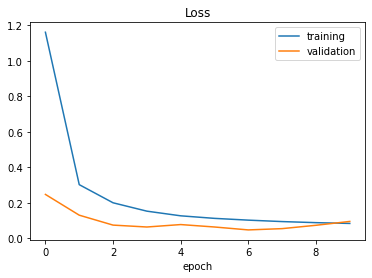

In [ ]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.legend(['training', 'validation']) 
plt.title('Loss') 
plt.xlabel('epoch') 

Text(0.5, 0, 'epoch')

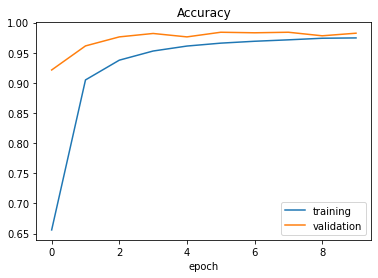

In [ ]:
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.legend(['training', 'validation']) 
plt.title('Accuracy') 
plt.xlabel('epoch') 

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 0) 
print('Test Loss: ', score[0]) 
print('Test Accuracy: ', score[1]) 
#https://www.geeksforgeeks.org/opencv-and-keras-traffic-sign-classification-for-self-driving-car/

Test Loss:  0.18009856391983123
Test Accuracy:  0.960490882396698


Lassen Sie uns ein Testbild überprüfen. Das Modell gibt eine Schätzung für die richtige Klasse 0 (Geschwindigkeitsbegrenzung 20).

Predicted sign: [0]


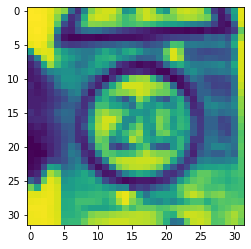

In [ ]:
plt.imshow(X_test[990].reshape(32, 32)) 
print("Predicted sign: "+ str( 
        model.predict_classes(X_test[990].reshape(1, 32, 32, 1))))
#https://www.geeksforgeeks.org/opencv-and-keras-traffic-sign-classification-for-self-driving-car/

Predicted sign: [11]


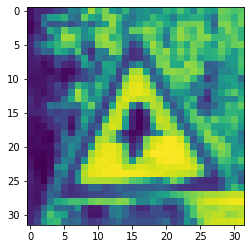

In [ ]:
plt.imshow(X_test[3000].reshape(32, 32)) 
print("Predicted sign: "+ str( 
        model.predict_classes(X_test[3000].reshape(1, 32, 32, 1))))
#https://www.geeksforgeeks.org/opencv-and-keras-traffic-sign-classification-for-self-driving-car/